In [7]:
import pandas as pd


In [8]:
#pegando os dados do yahoo
def load_equities_web(symbol, date_from):
    import pandas_datareader.data as web
    raw_data = web.DataReader(symbol, 'yahoo', pd.to_datetime(date_from), pd.datetime.now())
    data = raw_data.stack(dropna=False)['Adj Close'].to_frame().reset_index().rename(columns = {'Symbols':'symbol', 'Date':'date', 'Adj Close':'value'}).sort_values(by = ['symbol', 'date'])
    return pd.pivot_table(data, columns = 'symbol', index = 'date', values ='value')

In [9]:
#pegando preco dos ativos q serao utilizados
prices = load_equities_web(['SPY', '^GSPC', '^VIX'], date_from = '2000-01-01')

prices.isna().sum()#so para saber se tem alguma linha vazia
prices

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  after removing the cwd from sys.path.


symbol,SPY,^GSPC,^VIX
date,,,
2000-01-03,98.959030,1455.219971,24.209999
2000-01-04,95.089104,1399.420044,27.010000
2000-01-05,95.259193,1402.109985,26.410000
2000-01-06,93.728249,1403.449951,25.730000
2000-01-07,99.171638,1441.469971,21.719999
...,...,...,...
2020-07-06,317.049988,3179.719971,27.940001
2020-07-07,313.779999,3145.320068,29.430000
2020-07-08,316.179993,3169.939941,28.080000


In [10]:

def backtest_strategy(prices, symbol_trade, symbol_volatility, volatility_threshold, capital, symbol_benchmark): #volatility_threshold vai ajudar a definir o que é uma volatilidade baixa
    
                #pega na tabela price[simbolo] =0 e tbm coloca uma coluna cash
    df_init   = (prices[symbol_trade]*0).to_frame().assign(cash = 0)#lida com a posicao no inicio do dia
    df_update = (prices[symbol_trade]*0).to_frame().assign(cash = 0)#lida com as mudanças de posicao durante o dia
    df_end    = (prices[symbol_trade]*0).to_frame().assign(cash = 0)#lida com a posicao no fim do dia
    
    df_init.iloc[0, df_init.columns.get_loc('cash')] = capital#colocando capital incial na primeira linha do data frameINICIAL
    df_end.iloc[0, df_end.columns.get_loc('cash')]   = capital#colocando capital incial na primeira linha do data frameFINAL dia
    
    calendar = pd.Series(prices.index).iloc[1:]#pulando primeiro dia, que a gente nao faz trading e pegando todos od dias
    
    
    for date in calendar:
        prev_date = df_init.index[df_init.index<date][-1]#p/ saber qual é o dia anterior
        
        df_init.loc[date, :] = df_end.loc[prev_date, :]#fazendo inicio dia ser igual ao final dia do DiaAnterior
        
        port_value = df_init.loc[date, symbol_trade] * prices.loc[date, symbol_trade] + df_init.loc[date, 'cash']#valor do portifolio no inicio do dia= posiciao inicio dia*preço + valor em caixa
        
        #fazendo a trasicao entre caixa e comprado
        if prices.loc[date, symbol_volatility] > volatility_threshold: # volatility is high -> be fully in cash
            df_end.loc[date, symbol_trade] = 0
            df_end.loc[date, 'cash']       = port_value
        else: # volatility is low -> be in market position
            df_end.loc[date, symbol_trade] = port_value/prices.loc[date, symbol_trade]#divide pelo preco p colocar so a qtd alocada e n o valor
            df_end.loc[date, 'cash'] = 0
        df_update.loc[date] = df_end.loc[date] - df_init.loc[date]#passando a diferencao p o dfUpdate
    
    #comparação com benchmark
                      
    portval = (df_end*prices.assign(cash = 1)[[symbol_trade, 'cash']]).sum(axis = 1).to_frame().rename(columns = {0:'strategy'})#trocando qdt alocada pelo valor alocado e juntando as duas colunas- para dar uma coluna com o valor final de cada dia (strategy) 
    portval['benchmark'] = prices[symbol_benchmark]
    portval = portval/portval.iloc[0].values #normalizando o valor inicial
    
    return (portval,df_init,df_update, port_value)
    

,SPY,cash
date,,
2000-01-03,0.0,10000.00000
2000-01-04,0.0,10000.00000
2000-01-05,0.0,10000.00000
2000-01-06,0.0,10000.00000
2000-01-07,0.0,10000.00000
...,...,...
2020-07-06,0.0,20017.01435
2020-07-07,0.0,20017.01435
2020-07-08,0.0,20017.01435


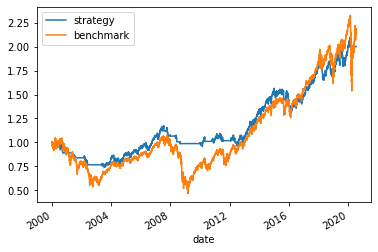

In [12]:
res ,df_init,df_update, port_value= backtest_strategy(prices = prices, symbol_trade = 'SPY', symbol_volatility = '^VIX', volatility_threshold = 20, capital = 10000, symbol_benchmark = '^GSPC')
res.plot()
df_init
#df_update
#port_value
#res.loc['2020'].plot()